In [38]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm

# I- Data preparation

We'll use a dataset of historical returns and realized covariance of the main stock market indexes (Eurostoxx 500, S&P 500,...). Realized covariance on day $t$ between index $i$ and $j$ is estimated by: 
$$Cov_{t,i,j} = \rho_{t,i,j} \sigma_{t,i} \sigma_{t,j}$$
Where $\rho_{t,i,j}$ is the historical correlation up to time $t$ between returns of index $i$ (60 days of returns) and $j$ and $\sigma_{t,i}$ is the realized volatility of index $i$ during day $t$ (computed with datapoints with a 5 minutes frequency during day $t$.)

In [86]:
df = pd.read_csv("oxfordmanrealizedvolatilityindices.csv")
df = df.rename(columns={'Unnamed: 0': 'date'})
df =df[~df['Symbol'].isin(['.MXX'])]
df['date'] = pd.to_datetime(df['date'])

#pivot pour passer de format long à wide 
pivot_prices = df.pivot(index='date', columns='Symbol', values='close_price')
pivot_rv5 = df.pivot(index='date', columns='Symbol', values='rv5')

#on combine les 2 pivot tables
combined = pivot_prices.join(pivot_rv5, lsuffix='_price', rsuffix='_rv')


#we toss the assets for wich there are more than 5% of missing values (and we will do forward fill on others)
threshold = len(combined) * 0.05
missing_counts = combined.isna().sum()
cols_to_drop = missing_counts[missing_counts > threshold].index
print(f"removed assets : {cols_to_drop.tolist()}")

combined = combined.drop(columns=cols_to_drop)
combined = combined.ffill()
combined = combined.dropna()



# Séparation après nettoyage
prices = combined.filter(like='_price')
variances = combined.filter(like='_rv')

# Renommage des colonnes pour avoir juste les symboles
prices.columns = [c.replace('_price', '') for c in prices.columns]
variances.columns = [c.replace('_rv', '') for c in variances.columns]

#Compute returns and realized covariances 
returns_df = prices.pct_change()
realized_vol_df = np.sqrt(variances)

# realign datasets 
valid_idx = returns_df.index.intersection(realized_vol_df.index)
returns_df = returns_df.loc[valid_idx].dropna()
realized_vol_df = realized_vol_df.loc[returns_df.index]

#Compute realized correlations (rollign window of 60 days)
# crée un objet MultiIndex (Date x Symbol) pour les corrélations
rolling_corr = returns_df.rolling(window=60).corr() 

# On doit supprimer les premiers jours (car on n'a pas les 60 premieres valeurs de correlation)
returns_df = returns_df.iloc[60:]
realized_vol_df = realized_vol_df.iloc[60:]
valid_dates = returns_df.index

#construction of the tensor containing realized covariances
T = len(valid_dates)
N = len(returns_df.columns)

# Structures finales
cov_tensor = np.zeros((T, N, N))
returns_matrix = returns_df.values

assets = returns_df.columns.tolist()
dates = valid_dates.values

for t, date in enumerate(valid_dates):
    # vector containing daily realized volatilities (oxford data)
    sigma_vec = realized_vol_df.loc[date].values
    
    # matrix of estimated realized covariance matrix, built from daily realized volatility and historical correlations (computed over 60 days)
    R = rolling_corr.loc[date].values
        
    # Cov = Sigma_outer * R
    # avec Sigma_outer = matrice des produits sigma_i * sigma_j pour la date t 
    Sigma_outer = np.outer(sigma_vec, sigma_vec)
    V_real = Sigma_outer * R
    
    cov_tensor[t, :, :] = V_real



data = {
    'dates': dates,
    'assets': assets,
    'returns': returns_matrix,      
    'realized_covs': cov_tensor     
}

C:\Users\jean-\AppData\Local\Temp\ipykernel_13384\2486482984.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['date'] = pd.to_datetime(df['date'])


removed assets : ['.BSESN_price', '.BVLG_price', '.BVSP_price', '.FTMIB_price', '.GSPTSE_price', '.HSI_price', '.KS11_price', '.KSE_price', '.N225_price', '.NSEI_price', '.OMXC20_price', '.OMXHPI_price', '.OMXSPI_price', '.OSEAX_price', '.SMSI_price', '.SSEC_price', '.STI_price', '.BSESN_rv', '.BVLG_rv', '.BVSP_rv', '.FTMIB_rv', '.GSPTSE_rv', '.HSI_rv', '.KS11_rv', '.KSE_rv', '.N225_rv', '.NSEI_rv', '.OMXC20_rv', '.OMXHPI_rv', '.OMXSPI_rv', '.OSEAX_rv', '.SMSI_rv', '.SSEC_rv', '.STI_rv']


Because of missing data in the dataset, we've kept only 14 indexes. These are the index for which there is no (or very little) missing data, with less than 5% of data missing. 

In [87]:
print("dates:",data['dates'][:5])
print("assets:",data['assets'])
print("first day return",data['returns'][0])
print("first day realized covariance",data['realized_covs'][0])

dates: [Timestamp('2000-03-29 00:00:00+0100', tz='UTC+01:00')
 Timestamp('2000-03-30 00:00:00+0100', tz='UTC+01:00')
 Timestamp('2000-03-31 00:00:00+0100', tz='UTC+01:00')
 Timestamp('2000-04-03 00:00:00+0100', tz='UTC+01:00')
 Timestamp('2000-04-04 00:00:00+0100', tz='UTC+01:00')]
assets: ['.AEX', '.AORD', '.BFX', '.DJI', '.FCHI', '.FTSE', '.GDAXI', '.IBEX', '.IXIC', '.RUT', '.SPX', '.SSMI', '.STOXX50E']
first day return [-0.00757333 -0.00034039 -0.00877328 -0.00390997 -0.0028846  -0.00841397
 -0.00413467 -0.01003186 -0.05330983 -0.0426826  -0.00865252  0.00526981
  0.00073599]
first day realized covariance [[ 7.89514278e-05  2.54291954e-05  3.16467526e-05  1.18229152e-05
   6.31398104e-05  4.60003804e-05  8.68504678e-05  5.74845429e-05
   9.26594239e-05  4.69091452e-05  2.83580079e-05  2.75185698e-05
   6.33600913e-05]
 [ 2.54291954e-05  5.10091529e-05  3.85181660e-06 -2.56814222e-06
   2.05984253e-05  1.70047171e-05  2.99972775e-05  1.12857803e-05
   3.27270983e-05  1.47984410e-05  

# II- Online portfolio construction

We'll compare the following portfolios:
- equal weights portfolio 
- Markowitz portfolio (without short-selling and leverage) on the average of returns and realized covariance on the last 60 days. 
- Markowitz portfolio (without short-selling and leverage) on the average of returns and realized covariance on the full history. This portfolio is equivalent to a Follow-The-Leader algorithm 
- Online gradient descent/FTRL portfolio with regularizer $R(w) = \frac{1}{2}\|w\|_2^2$:
$$w_{t+1} =  \arg\max_{w \in \Delta_N} \langle \nabla f_t(w_t),w \rangle - \frac{1}{2\eta}\|w-w_t\|_2^2 =  \arg\max_{w \in \Delta_N} \eta \sum_{s=0}^t f_s(w) - \frac{1}{2}\|w\|_2^2$$
$$ \Leftrightarrow w_{t+1} = \text{Proj}_{\Delta_N}(w_t + \eta \nabla f_t(w_t))$$
- Exponentiated gradient/FTRL with negative entropy regularizer:
$$ w_{t+1} =\arg\max_{w \in \Delta_N} \eta \sum_{s=0}^t f_s(w) + \sum_{i=1}^Nw_i log (w_i) $$
$$ \Leftrightarrow w_{t+1} = \left( \frac{e^{\eta \sum_{i=1}^{t}\nabla f_s(w_s)_k}}{\sum_{j=1}^Ne^{\eta \sum_{i=1}^{t}\nabla f_s(w_s)_j}}\right)_{ 1 \leq k \leq N} $$


Regarding the learning rate used by the online learning algorithms: we'll use the RMSProp approach to tune the learning rate, ie set: 
$$ \eta_t = \frac{\eta_{base}}{\sqrt{A_t} + \epsilon}$$
where $A_t =  \gamma A_{t-1} + (1- \gamma) \|\nabla f_t(w_t)\|^2$ is the quadratic moving average of the gradient.


In [88]:
#  projection on simplex of a vector v
def project_to_simplex(v):
    
    n = len(v)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, n + 1) > (cssv - 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1.0)
    w = np.maximum(v - theta, 0)
    return w

# quadratic program solver for markowitz portfolio
def solve_qp(mu_est, Sigma_est, risk_aversion):
    """
    Résout: Max w^T*mu - (lambda/2) * w^T*Sigma*w
    Sujet à: sum(w)=1, w>=0
    """
    N = len(mu_est)
    w = cp.Variable(N)
    gamma = cp.Parameter(nonneg=True, value=risk_aversion)
    # we add a small regularization to Sigma to ensure it's positive definite
    Sigma_est = Sigma_est + np.eye(N) * 1e-6

    # Objectif : Maximiser le rendement ajusté du risque
    # Note: cvxpy minimise, donc on minimise -(Rendement - Penalité)
    ret = mu_est @ w
    risk = cp.quad_form(w, cp.psd_wrap(Sigma_est))
    prob = cp.Problem(cp.Maximize(ret - (gamma / 2) * risk), 
                      [cp.sum(w) == 1, w >= 0])
    
    try:
        prob.solve(solver=cp.OSQP, warm_start=True) 
        return w.value
    except Exception as e:
        print("failed to compute markowitz solution",e)

In [92]:
dates = data['dates']
returns = data['returns']        
covs = data['realized_covs']     
assets = data['assets']

T, N = returns.shape

# Parameters of the model
lambda_reg = 1   # risk aversion parameter of utility functions
lr_ogd = 0.1 
lr_eg = 1         # Learning Rate for FTRL / OMD 
window = 60       # rolling window for Markowitz rolling mean 

ma_eg = 0.0  # Moving average of the gradient 
ma_ogd = 0.0
decay = 0.9        # decay factor 
lr_base_eg = 1.0      # Learning rate 
lr_base_ogd = 0.1      # Learning rate
epsilon = 1e-6     # to avoid dividing by zero

#initialization of variables 
#OGD
w_ogd = np.ones(N) / N
wealth_ogd = [1.0]

#OGD with adaptive learning date
w_ogd_ada = np.ones(N) / N
wealth_ogd_ada = [1.0]

#EG
w_eg = np.ones(N) / N
wealth_eg = [1.0]

#EG with adaptive learning date
w_eg_ada = np.ones(N) / N
wealth_eg_ada = [1.0]

#Markowitz Rolling 
w_marko_roll = np.ones(N) / N
wealth_marko_roll = [1.0]

#Markowitz Full History 
w_marko_full = np.ones(N) / N
wealth_marko_full = [1.0]

#Benchmark
wealth_eq = [1.0]

#history of weights 
hist_w_ogd = []
hist_w_ogd_ada = []
hist_w_eg = []
hist_w_eg_ada = []
hist_w_marko_roll = []
hist_w_marko_full = []


#we start the experiment at day 60 to have enough data to feed the markowitz portfolio
#but we need to warm up OMD before that even if we don't invest in it
for t in range(0, window):

    r_t = returns[t]
    V_t_real = covs[t]

    #gradient for OGD
    grad = r_t - lambda_reg * (V_t_real @ w_ogd)
    w_ogd = project_to_simplex(w_ogd + lr_ogd * grad)

    #gradient for OGD with adaptive rate
    grad = r_t - lambda_reg * (V_t_real @ w_ogd_ada)
    #update learning rate
    ma_ogd = decay*ma_ogd + (1-decay)*np.sum(grad**2)
    lr_ogd_ada = lr_base_ogd / (np.sqrt(ma_ogd) + epsilon)
    #compute portfolio
    w_ogd_ada = project_to_simplex(w_ogd + lr_ogd_ada * grad)

    #gradient for exponentiated gradient algorithm
    grad = r_t - lambda_reg * (V_t_real @ w_eg)
    w_eg = w_eg*np.exp(lr_eg * grad)/np.sum(w_eg*np.exp(lr_eg * grad))

    #gradient for EG with adaptive rate
    grad = r_t - lambda_reg * (V_t_real @ w_eg_ada)
    #update learning rate
    ma_eg = decay*ma_eg + (1-decay)*np.sum(grad**2)
    lr_eg_ada = lr_base_eg / (np.sqrt(ma_eg) + epsilon)
    #compute portfolio
    w_eg_ada = w_eg_ada*np.exp(lr_eg_ada * grad)/np.sum(w_eg_ada*np.exp(lr_eg_ada * grad))

for t in tqdm(range(window, T)):
    
    # we compute performance of portfolios on day t (from weights that were computed at t-1)
    r_t = returns[t]          
    V_t_real = covs[t]        
    
    ret_ogd = np.dot(w_ogd, r_t)
    ret_ogd_ada = np.dot(w_ogd_ada, r_t)
    ret_eg = np.dot(w_eg, r_t)
    ret_eg_ada = np.dot(w_eg_ada, r_t)
    ret_marko_roll = np.dot(w_marko_roll, r_t)
    ret_marko_full = np.dot(w_marko_full, r_t)
    ret_eq = np.mean(r_t)
    
    # update wealth of each portfolio
    wealth_ogd.append(wealth_ogd[-1] * (1 + ret_ogd))
    wealth_ogd_ada.append(wealth_ogd_ada[-1] * (1 + ret_ogd_ada))
    wealth_eg.append(wealth_eg[-1] * (1 + ret_eg))
    wealth_eg_ada.append(wealth_eg_ada[-1] * (1 + ret_eg_ada))
    wealth_marko_roll.append(wealth_marko_roll[-1] * (1 + ret_marko_roll))
    wealth_marko_full.append(wealth_marko_full[-1] * (1 + ret_marko_full))
    wealth_eq.append(wealth_eq[-1] * (1 + ret_eq))
    
    # update history of weights 
    hist_w_ogd.append(w_ogd)
    hist_w_ogd_ada.append(w_ogd_ada)
    hist_w_eg.append(w_eg)
    hist_w_eg_ada.append(w_eg_ada)
    hist_w_marko_roll.append(w_marko_roll)
    hist_w_marko_full.append(w_marko_full)
    

    # update portfolios for day t+1
    # 1. UPDATE OMD 
    # Gradient of f_t(w) = <r_t, w> - lambda/2 * w.T * V_t * w is:
    # Grad = r_t - lambda * V_t * w
    grad = r_t - lambda_reg * (V_t_real @ w_ogd)
    # gradient update and projection on simplex 
    w_temp = w_ogd + lr_ogd * grad
    w_ogd = project_to_simplex(w_temp)


    #1' UPDATE OMD WITH ADAPTIVE GRADIENT 
    #gradient for OGD with adaptive rate
    grad = r_t - lambda_reg * (V_t_real @ w_ogd_ada)
    #update learning rate
    ma_ogd = decay*ma_ogd + (1-decay)*np.sum(grad**2)
    lr_ogd_ada = lr_base_ogd / (np.sqrt(ma_ogd) + epsilon)
    #compute portfolio
    w_ogd_ada = project_to_simplex(w_ogd + lr_ogd_ada * grad)


    # 1''. UPDATE EG
    grad = r_t - lambda_reg * (V_t_real @ w_eg)
    w_eg = w_eg*np.exp(lr_eg * grad)/np.sum(w_eg*np.exp(lr_eg * grad))

    # 1''' UPDATE EG WITH ADAPTIVE GRADIENT
    #gradient for EG with adaptive rate
    grad = r_t - lambda_reg * (V_t_real @ w_eg_ada)
    #update learning rate
    ma_eg = decay*ma_eg + (1-decay)*np.sum(grad**2)
    lr_eg_ada = lr_base_eg / (np.sqrt(ma_eg) + epsilon)
    #compute portfolio
    w_eg_ada = w_eg_ada*np.exp(lr_eg_ada * grad)/np.sum(w_eg_ada*np.exp(lr_eg_ada * grad))

    
    # 2. UPDATE MARKOWITZ ROLLING
    idx_start = t - window + 1
    idx_end = t + 1
    mu_roll = np.mean(returns[idx_start:idx_end], axis=0)
    sigma_roll = np.mean(covs[idx_start:idx_end], axis=0)
    w_marko_roll = solve_qp(mu_roll, sigma_roll, lambda_reg)
    
    # 3. UPDATE MARKOWITZ FULL HISTORY (Depuis le début)
    mu_full = np.mean(returns[:idx_end], axis=0)
    sigma_full = np.mean(covs[:idx_end], axis=0)
    w_marko_full = solve_qp(mu_full, sigma_full, lambda_reg)
    


  0%|          | 0/4725 [00:00<?, ?it/s]

100%|██████████| 4725/4725 [02:50<00:00, 27.66it/s]


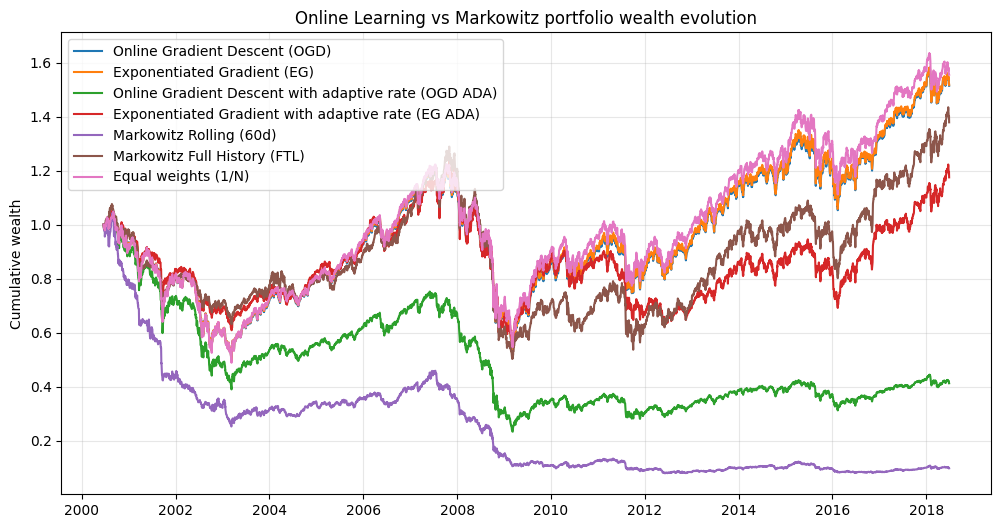

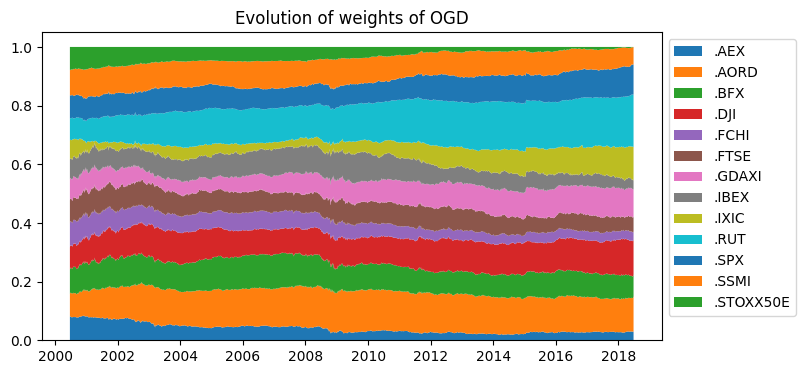

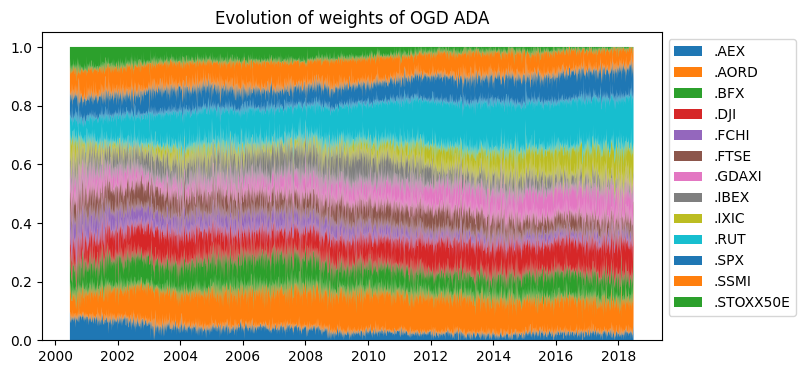

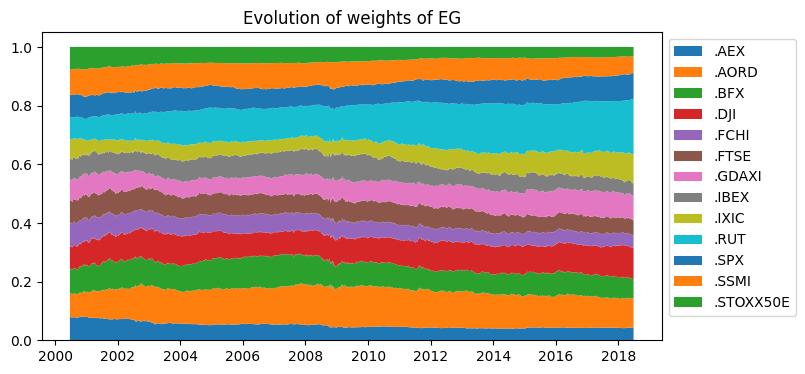

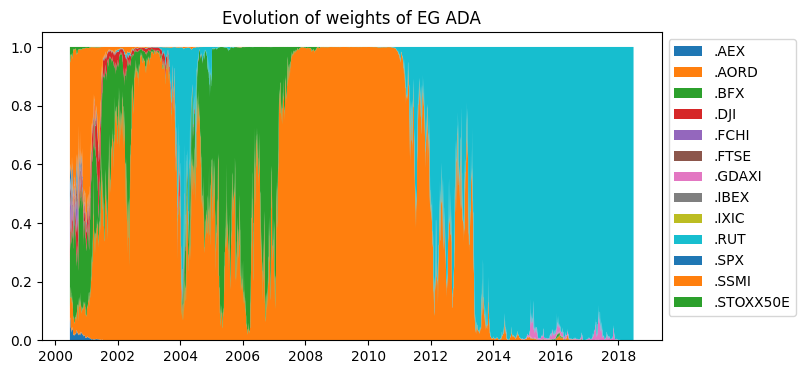

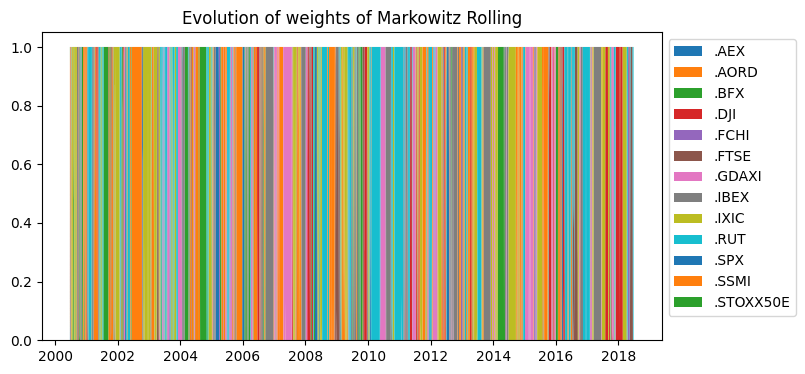

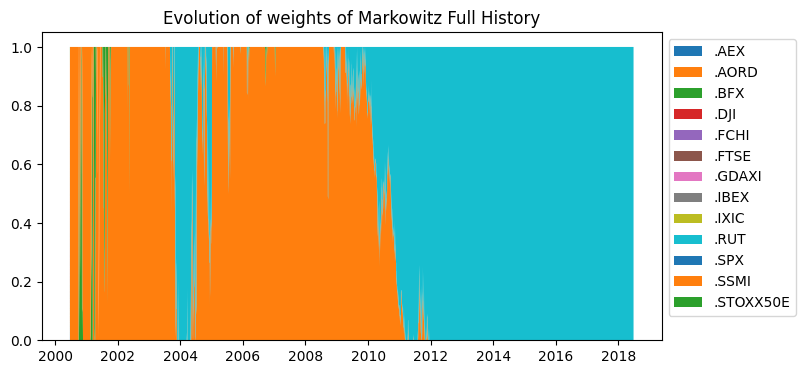

In [93]:
# --- VISUALISATION ---
plot_dates = dates[window-1:]

plt.figure(figsize=(12, 6))
plt.plot(plot_dates, wealth_ogd, label='Online Gradient Descent (OGD)')
plt.plot(plot_dates, wealth_eg, label='Exponentiated Gradient (EG)')
plt.plot(plot_dates, wealth_ogd_ada, label='Online Gradient Descent with adaptive rate (OGD ADA)')
plt.plot(plot_dates, wealth_eg_ada, label='Exponentiated Gradient with adaptive rate (EG ADA)')
plt.plot(plot_dates, wealth_marko_roll, label=f'Markowitz Rolling ({window}d)')
plt.plot(plot_dates, wealth_marko_full, label='Markowitz Full History (FTL)')
plt.plot(plot_dates, wealth_eq, label='Equal weights (1/N)')

plt.title("Online Learning vs Markowitz portfolio wealth evolution")
plt.ylabel("Cumulative wealth")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualisation des poids de Markowitz Full History
# Pour voir s'ils se figent avec le temps (Inertie)
for history,name in zip([hist_w_ogd, hist_w_ogd_ada, hist_w_eg, hist_w_eg_ada, hist_w_marko_roll,hist_w_marko_full],["OGD","OGD ADA","EG","EG ADA","Markowitz Rolling","Markowitz Full History"]):
    plt.figure(figsize=(8, 4))
    plt.stackplot(dates[window:], np.array(history).T, labels=assets)
    plt.title(f"Evolution of weights of {name}")
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.show()

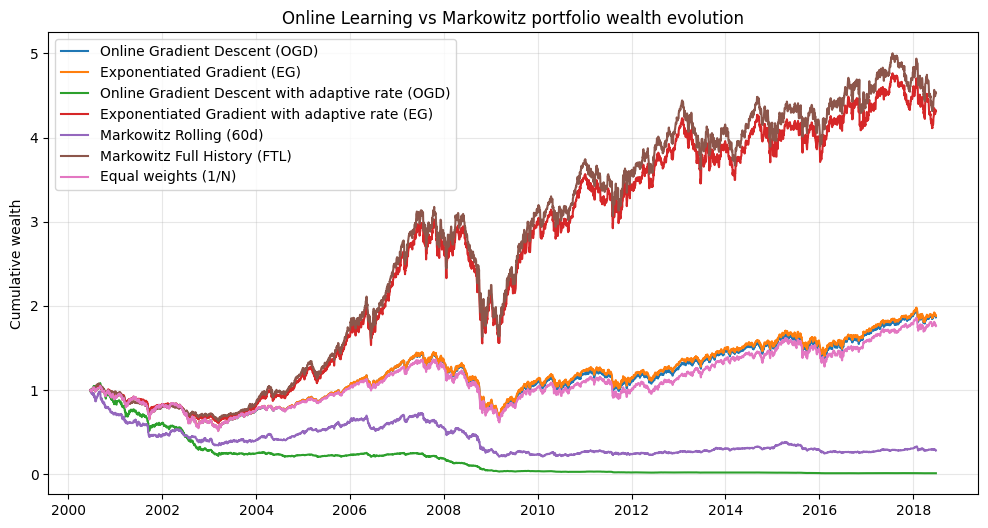

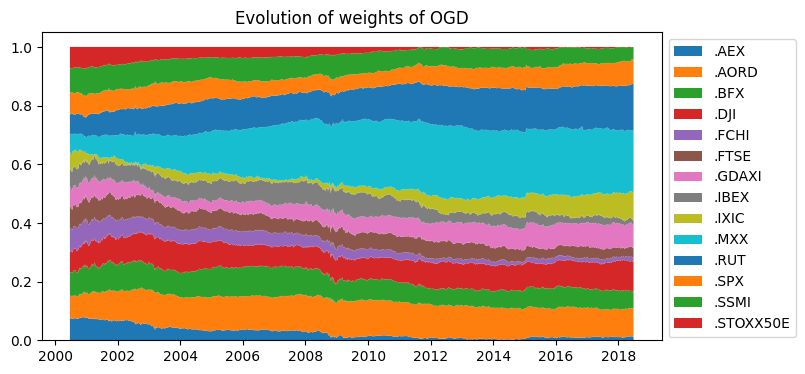

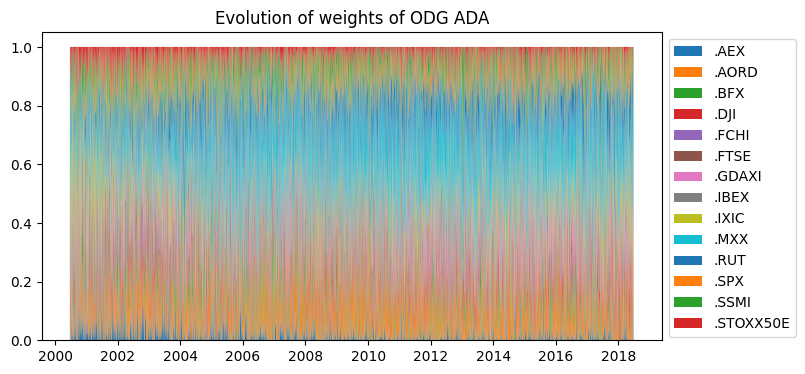

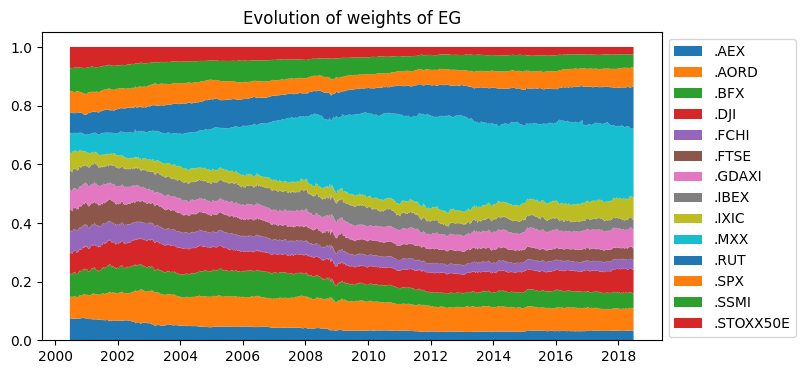

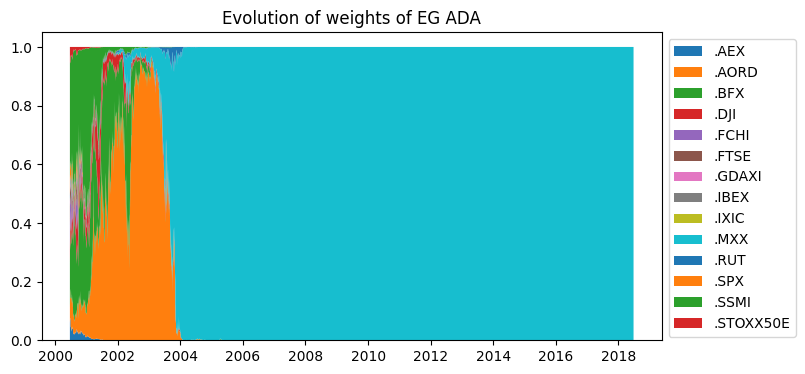

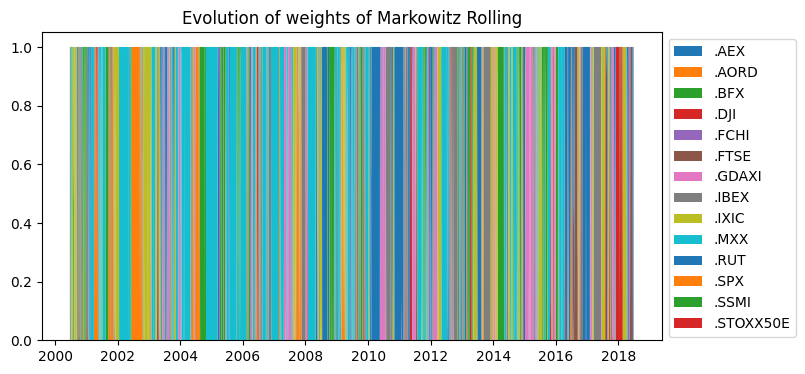

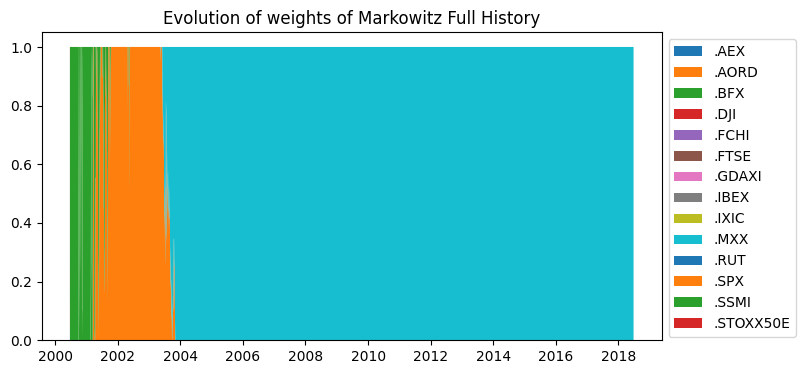

In [ ]:
# --- VISUALISATION ---
plot_dates = dates[window-1:]

plt.figure(figsize=(12, 6))
plt.plot(plot_dates, wealth_ogd, label='Online Gradient Descent (OGD)')
plt.plot(plot_dates, wealth_eg, label='Exponentiated Gradient (EG)')
plt.plot(plot_dates, wealth_ogd_ada, label='Online Gradient Descent with adaptive rate (OGD ADA)')
plt.plot(plot_dates, wealth_eg_ada, label='Exponentiated Gradient with adaptive rate (EG ADA)')
plt.plot(plot_dates, wealth_marko_roll, label=f'Markowitz Rolling ({window}d)')
plt.plot(plot_dates, wealth_marko_full, label='Markowitz Full History (FTL)')
plt.plot(plot_dates, wealth_eq, label='Equal weights (1/N)')

plt.title("Online Learning vs Markowitz portfolio wealth evolution")
plt.ylabel("Cumulative wealth")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualisation des poids de Markowitz Full History
# Pour voir s'ils se figent avec le temps (Inertie)
for history,name in zip([hist_w_ogd, hist_w_ogd_ada, hist_w_eg, hist_w_eg_ada, hist_w_marko_roll,hist_w_marko_full],["OGD","OGD ADA","EG","EG ADA","Markowitz Rolling","Markowitz Full History"]):
    plt.figure(figsize=(8, 4))
    plt.stackplot(dates[window:], np.array(history).T, labels=assets)
    plt.title(f"Evolution of weights of {name}")
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.show()